# 1. LangGraph底层原理

## 1.1 为什么用LangGraph

与仅限于使用`GPT`系列模型的`Assistant API`框架不同，`LangGraph`是一个适用范围更广的`AI Agent`开发框架。在**大模型的支持方面**，`LangGraph`不仅支持`GPT`系列，还兼容其他多种在线或开源模型，例如 `glm4`、`llama3`和`Qwen`等，可以说热门的大模型均可以接入到该框架中进行`AI Agent`应用程序的开发。而关于**大模型的接入方式**，我们既可以通过传统的`openai api`等原生方式将大模型集成到`LangGraph`构建的`AI Agent`流程中，也可以利用`ollma`、`vllm`等大模型推理加速库，实现更加便捷和高效的集成。除此之外，**在`AI Agent`的构建范式上**，`LangGraph`不仅提供了预配置的`ReAct`代理机制，还支持更多自定义的如`Planning`策略的接入，以满足不同应用场景的需求。

从三大方面来看，`LangGraph`的**高度自主性和开放性**确实让它在功能和灵活性上相较于`Assistant API`具有明显的优势。但需要注意的是，这种自主性和可扩展性也带来了更高的复杂性和开发要求。使用`LangGraph`意味着**开发者需要进行较多的自主开发工作**。此外，`LangGraph`框架的底层架构复杂非常复杂，这直接导致了`LangGraph`的学习和使用门槛相对较高。并且，经过我们长时间的探索和实践会明显发现，即使是经过多轮的尝试和优化，使用`LangGraph`构建的`AI Agent`应用程序的效果也很难超过用`Assistant API`几行代码就能实现的效果。所以，我们要想掌握和应用`LangGraph`，势必要投入更多的时间和精力。这是大家在开始学习前必须做好的心理准备。

## 1.2 什么是LangGraph

从名字上看，应该是和`Langchain`有着非常紧密的关系，而事实也确实是这样。**因为`LangGraph` 就是以 `LangChain` 表达式语言为基础而构建起来的用于开发`AI Agent`的一个框架**。所以我们上面提到的关于`LangGragh`在大模型的支持、接入和`AI Agent`构建方面的优势，都可以非常自然的从`LangChain`中迁移过来。从大模型技术发展的角度来看，**大模型本身是无法采取任何行动的，它们的作用只是用来输出文本**，即接收用户的输入并对这些输入给出响应。为了更好和更高效的做到这件事情，`langchain`项目在2023年就建立起了非常活跃的社区来定义大模型的应用规范。发展到现在，`LangChain`现在也发布了3个大的版本，而**在其整个的构建体系中，一个重要用例是创建代理**。在`LangChain`中，构建`AI Agent`的底层架构如下图所示：👇

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404031102489.png" width=80%></div>

首先，`langChain`框架中的`AI Agent`设计，在内部结构会将其分为三个核心的组件，分别是`Agent`，`Message`和`Toolkits`。每个`Agent`组件一般会由大语言模型 + 提示 + 输出解析器构成，形成一个`Chain`去处理用户的输入。而`Agent`能够处理的输入主要来源于三个方面：`input`代表用户的原始输入，`Model Response`指的是模型对某一个子任务的响应输出，而`History`则能携带上下文的信息。其输出部分，则链接到实际的工具库，需要调用哪些工具，将由经过`Agent`模块后拆分的子任务来决定。大模型调用外部函数会分为两个过程：识别工具和实际执行。在Message -> Agent -> Toolkits 这个流程中，负责的是将子任务拆解，然后根据这些子任务在工具库中找到相应的工具，提取工具名称及所需参数，这个过程可以视作一种“静态”的执行流程。而将这些决策转化为实际行动的工作，则会交给`AgentExecutor`。

在LangChain的`AI Agent`实际架构中，`Agent`的角色是接收输入并决定采取的操作，但它本身并不直接执行这些操作。这一任务是由`AgentExecutor`来完成的。将`Agent`（决策大脑）与`AgentExecutor`（执行操作的Runtime）结合使用，才构成了完整的`Agents`（智能体），**其中`AgentExecutor`负责调用代理并执行指定的工具**，以此来实现整个智能体的功能。

## 1.3 LangGraph底层原理

`LangChain`发展至现在，仍然是构建大语言模型应用程序的前沿框架之一。特别是在最新发布的`v0.3`版本中，已经基本完成了由传统类到表达式语言(LCEL)的重要过渡，给开发者带来的直接利好就是**定义和执行分步操作序列（也称为链）会更加简单**。用更专业的术语来说，**使用`LangChain` 构建的是 DAG（有向无环图）**。而之所以会出现`LangGraph`框架，根本原因是在于随着AI应用（特别是AI Agent）的发展，**对于大语言模型的使用不仅仅是作为执行工具，而更多作为推理引擎的需求在日益增长**。这种转变带来的是更多的重复（循环）和复杂条件的交互需求，这就导致**基于`LCEL`的线性序列构建方式在构建更复杂、更智能的系统时显示出了明显的局限性**。如下所示的代码就是在`LangChain`中通过`LECL`表达式语言构建`Chain`的一种最简单的方式：

In [ ]:
!pip install dashscope

In [2]:
from dotenv import load_dotenv
import os

load_dotenv('../config/.env')
os.environ["DASHSCOPE_API_KEY"] = os.getenv("QWEN_API_KEY")

In [6]:
from langchain_community.chat_models.tongyi import ChatTongyi
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate

In [7]:
llm = ChatTongyi(model="qwen-plus")

prompt = ChatPromptTemplate.from_messages(
    [
        ("system","You are a helpful assistant that translates {input_language} to {output_language}."),
        ("human", "{input}"),
    ]
)

chain = prompt | llm

chain.invoke(
    {
        "input_language": "English",
        "output_language": "Chinese",
        "input": "I love programming.",
    }
)

AIMessage(content='我热爱编程。', additional_kwargs={}, response_metadata={'model_name': 'qwen-plus', 'finish_reason': 'stop', 'request_id': 'a16d0891-b001-9a09-a834-c367b02f2e8c', 'token_usage': {'input_tokens': 32, 'output_tokens': 4, 'total_tokens': 36, 'prompt_tokens_details': {'cached_tokens': 0}}}, id='run--0d45f1aa-4a63-420e-a62f-79e76d88e09f-0')

反观`LangGraph`，顾名思义，`LangGraph` 在图这个概念上有很大的侧重，**它的出现就是`要解决线性序列的局限性问题，而解决的方法就是循环图`**。在`LangGraph`框架中，**用图取代了`LangChain`的`AgentExecutor`（代理执行器），用来管理代理的生命周期并在其状态内将暂存器作为消息进行跟踪，增加了以循环方式跨各种计算步骤协调多个链或参与者的功能。**这就与 `LangChain` 将代理视为可以附加工具和插入某些提示的对象不同，对于图来说，意味着**我们可以从任何可运行的功能或代理或链作为一个程序的起点**。


在以图构建的框架中，**任何可执行的功能都可以作为对话、代理或程序的启动点**。这个启动点可以是大模型的 `API` 接口、基于大模型构建的 `AI Agent`，通过 `LangChain` 或其他技术建立的线性序列等等，即下图中的 "Start" 圆圈所示。无论哪种形式，它都首先处理用户的输入，并决定接下来要做什么。下图展示了在 `LangGraph` 概念下，最基本的一种代理模型：👇

<div align=center><img src="https://muyu001.oss-cn-beijing.aliyuncs.com/img/1011002.png" width=50%></div>

**在启动点定义的可运行功能会根据收到的输入决定是否进行检索以及如何响应**。比如在执行过程中，如果需要检索信息，则可以利用搜索工具来实现，比如`Web Search`（网络搜索）、`Query Database`（查询数据库）、`RAG`等获取必要的信息（图中的 "Action" 圆圈）。接下来，再使用一个大语言模型（LLM）处理工具提供的信息，结合用户最初传入的初始查询，生成最终的响应（图中的 "LLMs" 圆圈）。最终，这个响应被传递至终点节点（图中的 "End" 圆圈）。

上图所示的流程就是在`LangGraph`概念中一个非常简单的代理构成形式。关键且必须清楚的概念是：在这里，**每个圆圈代表一个“节点”（Nodes），每个箭头表示一条“边”（Edges）。因此，在 `LangGraph` 中，无论代理的构建是简单还是复杂，它最终都是由节点和边通过特定的组合形成的图。这样的构建形式形成的工作流原理就是：当每个节点完成工作后，通过边告诉下一步该做什么，所以也就得出了：`LangGraph`的底层图算法就是在使用消息传递来定义通用程序。当节点完成其操作时，它会沿着一条或多条边向其他节点发送消息。然后，这些接收节点执行其功能，将结果消息传递给下一组节点，然后该过程继续。如此循环往复。**

在这个示例中，我们将`AI Agent`定义为应用程序的起点。**构建`AI Agent`代理通常涉及配置一个或多个工具**，否则构建它就没有太大的意义，因为如果仅仅是针对用户的问题直接做响应，即使问题很复杂，我们也可以直接通过提示词来引导大模型进行推理（参考`OpenAI`的 `o1`推理模型）。那么当`AI Agent`包含一些工具时，它是通过函数调用功能使用这些工具，而不是直接执行这些工具。所以当用户输入的原始问题经过`AI Agent`处理的时候，一般会出现以下两种情况：
1. 如果不需要调用任何工具，`AI Agent` 会直接提供一个针对用户问题的自然语言响应。例如：
   - 用户：你好，请你介绍一下你自己。
   - AI Agent：你好，我是一个人工智能助手，可以帮助你解决问题。
2. 如果需要调用工具，则输出将是一个特定格式的 JSON 输出，指示进行特定的函数调用。例如：
   - 输出示例：function': {'arguments': '{"query":"什么是快乐星球？"}','name': 'web_search'},'type': 'function'}

<div align=center><img src="https://muyu001.oss-cn-beijing.aliyuncs.com/img/101103.png" width=60%></div>

经过第一个节点后（Agent），如果`AI Agent`认为需要调用某个函数，它会确定使用哪个工具以及传递哪些参数。假设有多个工具可选的情况下，`Action` 节点将呈现多条可能的路径供选择。如何选择呢？这时候，`LangGraph` 引入了一个**称为“条件边”的组件。条件边根据是否满足特定条件来决定走哪条路径，例如，代理可能需要决定是使用搜索工具还是直接生成最终答案**。为了管理这些决策，则使用了一个类似于 `if-else` 语句的结构，称为`Router`。基于`Router`的决策，代理可能会导向“搜索节点”以执行搜索操作并返回原始文本，或者直接前往“最终答案节点”以获取格式化后的自然语言响应。**如果选择了搜索路径，获取的答案文本还需通过另一个大语言模型进行处理，以生成用户可以理解的响应；若选择了直接回答，则可以使用一个专门的工具来格式化输出**。

在 `LangGraph` 框架中，`Router` 使用 `if..else` 的形式来决定路径，主要通过以下三种方式实现：
- 提示工程：指示大模型以特定格式做出回应。
- 输出解析器：使用后处理从大模型响应中提取结构化数据。
- 工具调用：利用大模型的内置工具调用功能来生成结构化输出。

更进一步地，我们现在知道了`LangGraph`通过组合`Nodes`和`Edges`去创建复杂的循环工作流程，通过消息传递的方式串联所有的节点形成一个通路。**那么维持消息能够及时的更新并向该去的地方传递，则依赖`langGraph`构建的`State`概念。** 在`LangGraph`构建的流程中，每次执行都会启动一个状态，图中的节点在处理时会传递和修改该状态。这个状态不仅仅是一组静态数据，而是由每个节点的输出动态更新，然后影响循环内的后续操作。如下所示：👇

<div align=center><img src="https://muyu001.oss-cn-beijing.aliyuncs.com/img/101104.png" width=80%></div>

**此谓共享状态**。共享状态是指在执行期间在图内的节点之间传递的数据或信息。**`LangGraph`允许节点在图上执行时时通过共享和更新此公共状态来进行交互**。这种共享状态使节点能够根据它们共同维护的数据进行通信、交换信息并影响彼此的行为。通过利用共享状态， `LangGraph`才能够促进节点间操作的协调和同步，允许动态交互和创建复杂的工作流程，其中节点可以协作并根据可用的共享信息做出决策。

从`LangGraph`官方的定义看，该框架是一个**用于使用大模型构建有状态、多参与者应用程序的库，可以创建代理和多代理工作流程**。而其官方自己总结的`LangGraph`的优势则是：

- **循环和分支**：在应用程序中实现循环和条件。
- **持久性**：在图中的每个步骤之后自动保存状态。随时暂停和恢复图形执行，以支持错误恢复、人机交互工作流程、时间旅行等。
- **人机交互**：中断图形执行以批准或编辑代理计划的下一个操作。
- **流支持**：流输出由每个节点生成（包括令牌流）。
- **与 LangChain 集成**：LangGraph 与LangChain和LangSmith无缝集成（但不需要它们）。

## 1.4 LangGraph底层源码解析

### 1.4.1 Graph基类

对于任意一个简单或者复杂的图来说，都是基于`Graph`类来构建和管理图结构的。在`Graph`类中允许添加节点、边，并定义节点间的动态流转逻辑。如下是`Graph`类的主要组成部分和功能：

> Class Graph ：https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.graph.Graph

In [2]:
from collections import defaultdict
from typing import Any, Callable, Dict, Optional, Set, Tuple, Union, Awaitable, Hashable

class Graph:
    def __init__(self) -> None:
        self.nodes: Dict[str, Any] = {}  # 一个字典，用于存储图中的所有节点。每个节点可以是一个字符串标识或者是一个可调用对象
        self.edges: Set[Tuple[str, str]] = set()  # 一个集合，用来存储图中所有的边，边由一对节点名称组成，表示从一个节点到另一个节点的直接连接。
        self.branches: defaultdict = defaultdict(dict)  # 一个默认字典，用于存储条件分支，允许从一个节点根据特定条件转移到多个不同的节点。
        self.support_multiple_edges = False  # 一个布尔值，指示图是否支持同一对节点间的多条边。
        self.compiled = False    #  一个布尔值，表示图是否已经被编译。编译是指图的结构已经设置完毕，准备进行执行。

    @property
    def _all_edges(self) -> Set[Tuple[str, str]]:
        """
        获取所有边的数据。
        """
        return self.edges

    def add_node(self, node: Union[str, Callable], action: Optional[Callable] = None, *, metadata: Optional[Dict[str, Any]] = None) -> 'Graph':
        """
        添加一个新节点到图中。节点可以有附加的元数据，这些元数据存储在节点的字典中。
        """
        pass

    def add_edge(self, start_key: str, end_key: str) -> 'Graph':
        """
        在图中添加一条边，连接两个指定的节点。
        """
        pass

    def add_conditional_edges(self, source: str, path: Callable, path_map: Optional[Dict[Hashable, str]] = None, then: Optional[str] = None) -> 'Graph':
        """
        添加一个条件边，允许在执行时根据某个条件从一个节点动态地转移到一个或多个节点。
        """
        pass

    def set_entry_point(self, key: str) -> 'Graph':
        """
        设置图的入口点，即定义图执行的起始节点。
        """
        pass

    def set_conditional_entry_point(self, path: Callable, path_map: Optional[Dict[Hashable, str]] = None, then: Optional[str] = None) -> 'Graph':
        """
        设置一个条件入口点，允许根据条件动态决定图的起始执行点。
        """
        pass

    def set_finish_point(self, key: str) -> 'Graph':
        """
        设置结束点，定义图执行到此节点时将停止。
        """
        pass

    def validate(self, interrupt: Optional[Set[str]] = None) -> 'Graph':
        """
        验证图的结构是否正确，确保所有节点和边的定义都符合逻辑和图的规则。
        """
        pass

    def compile(self, checkpointer=None, interrupt_before: Optional[Set[str]] = None, interrupt_after: Optional[Set[str]] = None, debug: bool = False) -> 'Graph':
        """
        编译图，确认图的结构合法且可执行后，准备图以供执行。
        """
        pass

从源码中可以看出，`Graph`该类提供了丰富的方法来控制图的编译和执行，使其适用于需要复杂逻辑和流程控制的应用场景。

### 1.4.2 GraphState

**定义图时要做的第一件事是定义图的`State`**。状态表示会随着图计算的进行而维护和更新的上下文或记忆。它用来确保图中的每个步骤都可以访问先前步骤的相关信息，从而可以根据整个过程中积累的数据进行动态决策。这个过程通过状态图`StateGraph`类实现，它继承自 `Graph` 类，这意味着 `StateGraph` 会使用或扩展基类的属性和方法。

> Class StateGraph：https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.state.StateGraph

In [5]:
from collections import defaultdict
from typing import Any, Callable, Dict, Optional, Set, Tuple, Type, Union

class StateGraph(Graph):

    """StateGraph 是一个管理状态并通过定义的输入和输出架构支持状态转换的图。"""
    def __init__(self, state_schema: Optional[Type[Any]] = None, config_schema: Optional[Type[Any]] = None) -> None:
        super().__init__()
        self.state_schema = state_schema      # 一个可选的类型参数，定义图状态的结构。这是用于定义和验证图中节点处理的状态数据的模式。
        self.config_schema = config_schema    # 一个可选的类型参数，用于定义配置的结构。这可以用于定义和验证图的配置参数。
        self.input: Optional[Type[Ang]] = None
        self.output: Optional[Type[Ang]] = None

    def add_node(self, node: Union[str, Callable], action: Optional[Callable] = None, *, metadata: Optional[Dict[str, Any]] = None) -> 'StateGraph':
        """向图中添加一个新节点。节点可以是一个具名字符串或一个可调用对象（如函数）, 如果node是字符串，则action应为与节点关联的可调用动作。"""
        pass

    def add_edge(self, start_key: str, end_key: str) -> 'StateGraph':
        """在图中添加一条边，连接两个节点。"""
        pass

    def compile(self) -> 'CompiledStateGraph':
        """编译图，将其转换成可运行的形式。包括验证图的完整性、预处理数据等。"""
        pass

- **什么是图的模式**

**默认情况下，`StateGraph`使用单模式运行，这意味着在图中的任意阶段都会读取和写入相同的状态通道，所有节点都使用该状态通道进行通信**。除此之外，在某些情况下如果希望对图的状态有更多的控制，比如：
- 内部节点可以传递图的输入/输出中不需要的信息。
- 对图使用不同的输入/输出模式。例如，输出可能仅包含单个相关输出键。

`LangGraph`的底层实现上提供了多种不同图模式的支持，这可以通过`state_schema`来进行灵活的指定。不过关于自定义的图模式，因为涉及到更多的基础概念，我们将在课程的后半部分在展开详细的介绍。

首先来看图的单模式。任何模式都包含输入和输出，输入模式需要确保提供的输入与预期结构匹配，而输出模式根据定义的输出模式过滤内部数据以仅返回相关信息。而这个预期结构的校验，由`TypedDict`工具来限定。

- **TypeDict** 

`TypedDict` 是 `Python` 类型注解系统中的一个工具，它**允许为字典中的键指定期望的具体类型**。在 `Python` 的 `typing` 模块中定义，通常用于增强代码的可读性和安全性，特别是在字典对象结构固定且明确时。示例代码如下：

In [4]:
from typing import TypedDict

class Contact(TypedDict):
    name: str
    email: str
    phone: str

def send_email(contact: Contact) -> None:
    print(f"Sending email to {contact['name']} at {contact['email']}")

# 使用定义好的 TypedDict 创建字典
contact_info: Contact = {
    'name': 'Alice',
    'email': 'alice@example.com',
    'phone': '123-456-7890'
}

send_email(contact_info)

Sending email to Alice at alice@example.com


In [6]:
from langgraph.graph import StateGraph
from typing_extensions import TypedDict


# 定义输入的模式
class InputState(TypedDict):
    question: str


# 定义输出的模式
class OutputState(TypedDict):
    answer: str


# 将 InputState 和 OutputState 这两个 TypedDict 类型合并成一个字典类型。
class OverallState(InputState, OutputState):
    pass

接下来，创建一个 `StateGraph` 对象，使用 `OverallState` 作为其状态定义，同时指定了输入和输出类型分别为 `InputState` 和 `OutputState`，代码如下：

In [8]:
builder = StateGraph(OverallState, input_schema=InputState, output_schema=OutputState)

创建 `builder` 对象后，相当于构建了一个图结构的框架。接下来的步骤是向这个图中添加节点和边，完善和丰富图的内部执行逻辑。

### 1.4.3 Node

在 `LangGraph` 中，节点是一个 `python` 函数（sync 或async ），接收当前`State`作为输入，执行自定义的计算，并返回更新的`State`。所以其中第一个位置参数是`state` 。

In [9]:
def agent_node(state:InputState):
    print("我是一个AI Agent。")
    return

def action_node(state:InputState):
    print("我现在是一个执行者。")
    return {"answer":"我现在执行成功了"}

定义好了节点以后，我们需要使用`add_node`方法将这些节点添加到图中。在将节点添加到图中的时候，可以自定义节点的名称。而如果不指定名称，则会为自动指定一个与函数名称等效的默认名称。代码如下：

In [10]:
builder.add_node("agent_node", agent_node)
builder.add_node("action_node", action_node)

现在有了图结构，并且图结构中也存在两个孤立的节点`agent_node`和`action_node`，接下来我们要做的事就是需要将图中的节点按照我们所期望的方式进行连接，这需要用到的就是`Edges` - 边。

### 1.4.4 Edge

Edges（边）用来定义逻辑如何路由以及图何时开始与停止。这是代理工作以及不同节点如何相互通信的重要组成部分。有几种关键的边类型：
- 普通边：直接从一个节点到下一个节点。
- 条件边：调用函数来确定下一个要转到的节点。
- 入口点：当用户输入到达时首先调用哪个节点。
- 条件入口点：调用函数来确定当用户输入到达时首先调用哪个节点。

In [11]:
from langgraph.graph import START, END

builder.add_edge(START, "agent_node")
builder.add_edge("agent_node", "action_node")
builder.add_edge("action_node", END)

最后，通过`compile`编译图。在编译过程中，会对图结构执行一些基本检查（如有没有孤立节点等）。代码如下：

In [12]:
graph = builder.compile()

### 1.4.5 Graph的调用方法

要调用图中的方法，可以使用 `invoke` 方法。示例代码如下：

In [13]:
graph.invoke({"question":"你好"})

我是一个AI Agent。
我现在是一个执行者。


{'answer': '我现在执行成功了'}

在这个过程中，我们将`state: InputState`作为输入模式传递给`agent_node`，在传递到`action_node`，最后由`action_node`传递到`END`节点。节点之间通过边是已经构建了完整的通路，那么如果我们想要传递每个节点的状态信息，则可以稍加修改即可实现。对于图模式，我们的定义方法如下：

In [38]:
from langgraph.graph import StateGraph
from typing_extensions import TypedDict
from langgraph.graph import START, END

# 定义输入的模式
class InputState(TypedDict):
    question: str


# 定义输出的模式
class OutputState(TypedDict):
    answer: str


# 将 InputState 和 OutputState 这两个 TypedDict 类型合并成一个更全面的字典类型。
class OverallState(InputState, OutputState):
    pass

def agent_node(state: InputState):
    print("我是一个AI Agent。")
    return {"question": state["question"]}

def action_node(state: InputState):
    print("我现在是一个执行者。")
    step = state["question"]
    return {"answer": f"我接收到的问题是：{step}，读取成功了！"}

In [39]:
# 明确指定它的输入和输出数据的结构或模式
builder = StateGraph(OverallState, input_schema=InputState, output_schema=OutputState)

# 添加节点
builder.add_node("agent_node", agent_node)
builder.add_node("action_node", action_node)

# 添加便
builder.add_edge(START, "agent_node")
builder.add_edge("agent_node", "action_node")
builder.add_edge("action_node", END)

# 编译图
graph = builder.compile()

In [40]:
graph.invoke({"question":"今天的天气怎么样？"})

我是一个AI Agent。
我现在是一个执行者。


{'answer': '我接收到的问题是：今天的天气怎么样？，读取成功了！'}

不同节点间能够传递信息的原因是因为节点可以写入图状态中的任何状态通道。图状态是初始化时定义的状态通道的并集，而我们定义的状态通道包含了`OverallState`以及过滤器`InputState`和`OutputState` 。

上述代码实际上中途没有更新state

## 1.5 使用LangGraph构建大模型的问答流程

首先，`LangGraph`对目前主流的在线或者开源模型均支持接入，所以大家可以在该框架下非常便捷的应用到自己偏爱的大模型来进行问答流程的构建。这下面的示例中，我们选择比较方便且高效的`LangChain`框架，同时使用`OpenAI`的`GPT`模型来进行案例实现。而关于`LangChain`支持接入的模型列表及方式，大家可以在`LangChain Docs`中查阅：https://python.langchain.com/docs/integrations/chat/ 或者 https://python.langchain.com/docs/integrations/llms/ 。

In [41]:
from langgraph.graph import StateGraph
from typing_extensions import TypedDict
from langgraph.graph import START, END

# 定义输入的模式
class InputState(TypedDict):
    question: str

# 定义输出的模式
class OutputState(TypedDict):
    answer: str

# 将 InputState 和 OutputState 这两个 TypedDict 类型合并成一个更全面的字典类型。
class OverallState(InputState, OutputState):
    pass

In [42]:
from dotenv import load_dotenv
import os

# 加载 .env 文件
load_dotenv('../config/.env')

# 获取模型 API 密钥
model_api_key = os.getenv("QWEN_API_KEY")

In [49]:
from openai import OpenAI

def llm_node(state: InputState):
    messages = [
        {"role":"system", "content":"你是一位乐于助人的智能小助理"},
        {"role":"user", "content":state["question"]}
    ]
    llm = OpenAI(
        api_key=model_api_key,
        base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"
    )

    completion = llm.chat.completions.create(
        model="qwen-turbo-2025-04-28",
        messages=messages,
        extra_body={
            "enable_search": False,
            "enable_thinking": False
        }
    )
    response = completion.choices[0].message.content
    return {"answer": response}

In [50]:
# 明确指定它的输入和输出数据的结构或模式
builder = StateGraph(OverallState, input_schema=InputState, output_schema=OutputState)

# 添加节点
builder.add_node("llm_node", llm_node)

# 添加便
builder.add_edge(START, "llm_node")
builder.add_edge("llm_node", END)

# 编译图
graph = builder.compile()

In [51]:
graph.invoke({"question":"你好，我用来测试"})

{'answer': '你好呀！很高兴认识你～我是你的智能小助理，有什么问题或者需要帮忙的地方都可以告诉我哦。你刚才说是在测试，是想看看我的功能吗？我可以帮你解答问题、提供信息，或者陪你聊天。你想试试看什么呢？😊'}

更进一步地，如果想在原有的图结构中构建更复杂的功能，则只需要新定义一个`Python`函数，并按照自己的预期流程用边来建立连接，如下代码所示：

In [52]:
from langgraph.graph import StateGraph
from typing_extensions import TypedDict, Optional
from langgraph.graph import START, END

# 定义输入的模式
class InputState(TypedDict):
    question: str
    llm_answer: Optional[str]  # 表示 answer 可以是 str 类型，也可以是 None，想要记录state，这里需要有数据类型

# 定义输出的模式
class OutputState(TypedDict):
    answer: str

# 将 InputState 和 OutputState 这两个 TypedDict 类型合并成一个更全面的字典类型。
class OverallState(InputState, OutputState):
    pass

In [53]:
def llm_node(state: InputState):
    messages = [
        {"role":"system", "content":"你是一位乐于助人的智能小助理"},
        {"role":"user", "content":state["question"]}
    ]
    llm = OpenAI(
        api_key=model_api_key,
        base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"
    )

    completion = llm.chat.completions.create(
        model="qwen-turbo-2025-04-28",
        messages=messages,
        extra_body={
            "enable_search": False,
            "enable_thinking": False
        }
    )
    response = completion.choices[0].message.content
    return {"llm_answer": response}

In [54]:
def action_node(state: InputState):
    messages = [
        {"role":"system", "content":"无论你接收到什么语言的文本，请翻译成法语"},
        {"role":"user", "content":state["llm_answer"]}
    ]
    
    llm = OpenAI(
        api_key=model_api_key,
        base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"
    )
    completion = llm.chat.completions.create(
        model="qwen-turbo-2025-04-28",
        messages=messages,
        extra_body={
            "enable_search": False,
            "enable_thinking": False
        }
    )
    response = completion.choices[0].message.content

    return {"answer": response}

In [56]:
builder = StateGraph(OverallState, input_schema=InputState, output_schema=OutputState)

# 添加节点
builder.add_node("llm_node", llm_node)
builder.add_node("action_node", action_node)

# 添加便
builder.add_edge(START, "llm_node")
builder.add_edge("llm_node", "action_node")
builder.add_edge("action_node", END)

# 编译图
graph = builder.compile()

In [57]:
final_answer = graph.invoke({"question":"你好，请你详细的介绍一下你自己"})
final_answer["answer"]

"Bonjour ! C'est un plaisir de discuter avec vous. Je suis un assistant intelligent qui aime aider les autres. Mon nom est Tongyi Qianwen. Bien que je n'aie pas d'apparence physique réelle, je peux communiquer avec vous par le texte, vous aider à répondre à des questions, créer des textes, exprimer des opinions, etc.\n\nJe peux faire beaucoup de choses ! Par exemple :\n\n- Vous aider à écrire des histoires, des documents officiels, des e-mails, des scénarios, etc.\n- Vous raconter des blagues, des histoires, des connaissances\n- Faire des exercices mathématiques ou apprendre des mots ensemble\n- Discuter avec vous et vous tenir compagnie\n\nBien que je ne puisse pas ressentir des émotions comme les humains, je fais de mon mieux pour comprendre vos sentiments et vous répondre avec des paroles chaleureuses. Si vous avez besoin d'aide ou si vous voulez simplement parler à un ami, je serai très heureux de vous servir.\n\nAu fait, j'ai une capacité spéciale : je peux me souvenir du contenu 

当深入理解了`LangGraph`的底层原理及其图结构构建的逻辑后，我们是可以明显感受到其相较于`LangChain`中的`AI Agent`架构，展现出了更高的灵活性和扩展性。在`LangGraph`中，我们可以在各个`Python`函数中定义节点的核心逻辑，并通过边来确定输入与输出模式。此外，节点函数在定义时还可以自主构建中间状态的信息。尽管在本示例中我们使用`LangChain`来接入大模型，但通过节点函数的定义逻辑来看，我们当然也可以完全不依赖`LangChain`，而采用原生方法进行接入。

由此可见，正如课程开始阶段所提到的，**虽然`LangGraph`是基于`LangChain`的表达式语言构建的，但它完全可以脱离`LangChain`而独立运行**。总体来看，今天的示例并不复杂，但涉及的知识点和细节颇多。强烈建议大家亲自尝试和体验一下，打好扎实的基础，才能更好的开展接下来复杂循环图的学习。

# 2. LangGraph的State状态模式与LangSmith基础使用入门

**在`AI Agent`应用程序的设计中，场景的复杂性直接决定了构建图的复杂度**。例如，最简单的场景可能仅涉及一个大模型的问答流程，形式为：START -> Node -> END（其中大模型的交互逻辑被封装在Node中）。而更复杂的场景则可能涉及多个`AI Agent`的协同工作，包括多个分支和循环的构成。无论是简单还是复杂的图，`LangGraph`的价值永远不在于如何去定义节点，如何去定义边，而是在于**如何有效管理各个节点的输入和输出，以保持图的持续运行状态**。`LangGraph`的**底层图算法采用消息传递机制来定义和执行这些图中的交互流程，其中状态（State）组件扮演着关键的载体角色，负责在图的各个节点之间传递信息**。这也就意味着，**`LangGraph`框架的核心在于`State`的有效使用和掌握。在复杂的应用中，`State`组件需要存储和管理的信息量会显著增加。核心功能如工具使用、记忆能力和人机交互等，都依赖`State`来实现和维护**。所以，接下来我们对`LangGragh`框架的探索，都将紧密围绕`State`的实现和应用机制展开，这包括`LangGraph`内置封装好的工具/方法的使用，以及我们自定义构建功能时的实现方法。

在本节课中，我们将详细探讨消息（Messages）是如何通过`State`进行传递的，其中包含了什么传递模式和内容。

## 2.1 LangGraph中State的定义模式

<div align=center><img src="https://muyu001.oss-cn-beijing.aliyuncs.com/img/20241022009.png" width=100%></div>

`LangGraph`构建的**图中的每个节点都具备访问、读取和写入状态的权限。当某一个节点去修改状态时，它会将此信息广播到图中的所有其他节点。这种广播机制允许其他节点响应状态的变化并相应地调整其行为**。如上图所示，从初始状态（Initial State）开始，其中包含了一条消息 { "x": "10" }，随着消息在节点间通过边传递，每个节点根据其逻辑对状态进行更新。Node 1 和 Node 2 分别对状态进行了处理和变更，结果是在图的末端，我们得到了一个包含三条消息的最终状态 { "x": "10" }, { "x": "11" }, { "y": "9" }。**从开发的角度来看，`State`实际上是一个共享的数据结构。如上图所示，状态表现为一个简单的字典。通过对这个字典进行读写操作，可以实现自左而右的数据流动，从而构建一个可运行的图结构**。我们可以利用这个流程来复现并理解图中的动态数据交换，整体的设计如下：

<div align=center><img src="https://muyu001.oss-cn-beijing.aliyuncs.com/img/20241022005.png" width=100%></div>

### 2.1.1 使用字典类型定义状态

In [23]:
from langgraph.graph import StateGraph

# 构建图
builder = StateGraph(dict) 

In [24]:
def addition(state):
    print(state)
    return {"x": state["x"] + 1}

def subtraction(state):
    print(state)
    return {"y": state["x"] - 2}

In [25]:
from langgraph.graph import START, END


# 向图中添加两个节点
builder.add_node("addition", addition)
builder.add_node("subtraction", subtraction)

# 构建节点之间的边
builder.add_edge(START, "addition")
builder.add_edge("addition", "subtraction")
builder.add_edge("subtraction", END)

In [26]:
builder.edges

{('__start__', 'addition'),
 ('addition', 'subtraction'),
 ('subtraction', '__end__')}

In [27]:
builder.nodes

{'addition': StateNodeSpec(runnable=addition(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None, input_schema=<class 'dict'>, retry_policy=None, cache_policy=None, ends=(), defer=False),
 'subtraction': StateNodeSpec(runnable=subtraction(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None, input_schema=<class 'dict'>, retry_policy=None, cache_policy=None, ends=(), defer=False)}

In [28]:
graph = builder.compile()

`LangGraph`提供的三种图形可视化方法如下：

- **Mermaid.Ink**：一个开源服务，可以根据 Mermaid 代码生成图表的 URL。它通过 API 提供多种输出格式，包括 PNG、JPEG、SVG 和 PDF，并可以自定义尺寸、主题和背景颜色等选项。开源仓库👉：[mermaid](https://github.com/mermaid-js/mermaid)
- **Mermaid + Pyppeteer**：使用 Mermaid 结合 Pyppeteer 的主要区别在于如何将 Mermaid 图表转换成图像或其他格式。Mermaid 本身是一个轻量级的工具，用于通过文本描述生成图表的图形表示。而 Pyppeteer 是一个 Python 库，它提供了一个接口来控制 Chrome，自动打开包含 Mermaid 图表的网页，然后通过浏览器自动截图功能捕获这些图表，生成图像文件。
- **Graphviz**：Graphviz 是一个图形可视化软件，主要用于自动图形布局。它非常适合于复杂图形的生成，如有向图和无向图，而且它支持多种格式的图像输出，如 PNG、SVG、PDF 等，有更精细的布局控制。

https://langchain-ai.github.io/langgraph/how-tos/visualization/

如果是`Linux`操作系统，建议使用`Graphviz`工具。而`Windows`系统建议使用`Mermaid + Pyppeteer`方法，因为在`Windwos`中`Graphviz`并不能直接通过 `pip install`的形式安装，编译安装的方法较为复杂。这里我们就使用`Mermaid + Pyppeteer`来进行图的可视化操作。首先，在当前的虚拟环境中安装依赖包，执行如下代码：

In [ ]:
#!pip install pyppeteer ipython

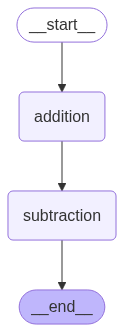

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

当通过 `builder.compile()` 方法编译图后，编译后的 `graph` 对象提供了 `invoke` 方法，该方法用于启动图的执行。我们可以通过 `invoke` 方法传递一个初始状态（如 `initial_state = {"x": 10}`），这个状态将作为图执行的起始输入。代码如下：

In [29]:
# 定义一个初始化的状态
initial_state = {"x": 10}

graph.invoke(initial_state)

{'x': 10}
{'x': 11}


{'y': 9}

在图的执行过程中，每个节点的函数会被调用，并且接收到前一个节点返回的状态作为输入。每个函数处理完状态后，会输出一个新的状态，传递给下一个节点。这里需要注意的一个关键信息是：**节点函数不需要返回整个状态，而是仅返回它们更新的部分**。也就是说：在每个节点的函数内部逻辑中，需要使用和更新哪些`State`中的参数中，只需要在`return`的时候指定即可，不必担心未在当前节点处理的State中的其他值会丢失，因为LangGraph的内部机制已经自动处理了状态的合并和维护。

In [14]:
for step in graph.stream({"x": 10}):
    print(step)  # 每个 step 都是 {节点名: state更新}

{'x': 10}
{'addition': {'x': 11}}
{'x': 11}
{'subtraction': {'y': 9}}


<div align=center><img src="https://muyu001.oss-cn-beijing.aliyuncs.com/img/202410220010.png" width=100%></div>

总体来看，该图设置了一个简单的工作流程。其中值首先在第一个节点通过加法函数增加，然后在第二个节点通过减法函数减少。这一流程展示了节点如何通过图中的共享状态进行交互。需要注意的是，**状态在任何给定时间只包含来自一个节点的更新信息。这意味着当节点处理状态时，它只能访问与其特定操作直接相关的数据，从而确保每个节点的逻辑是隔离和集中的**。使用字典作为状态模式非常简单，**由于缺乏预定义的模式，节点可以在没有严格类型约束的情况下自由地读取和写入状态，这样的灵活性有利于动态数据处理**。然而，这也要求开发者在整个图的执行过程中保持对键和值的一致性管理。因为如果在任何节点中尝试访问State中不存在的键，会直接中断整个图的运行状态。

到此为止，我们可以来思考一个问题：既然所有节点都会向状态（State）发出更新，为什么仅通过返回需要更新的键值，就能实现状态的全局共享呢？除此之外，如果我们需要对状态进行更复杂的操作，如新增、删除或修改等，应该如何构造这些操作呢？这就引出了我们需要深入理解的概念——在 `LangGraph` 中如何利用 `Reducer` 函数来精细控制状态的变化。

In [20]:
steps = list(graph.stream({"x": 10}))
print("all steps:", steps)

{'x': 10}
{'x': 11}
all steps: [{'addition': {'x': 11}}, {'subtraction': {'y': 9}}]


可见对于x的打印都是过程输出

### 2.1.2 Reducer函数的机制

`LangGraph`内部**原理是：`State`中的每个`key`都有自己独立的`Reducer`函数，通过指定的`reducer`函数应用状态值的更新。**

`Reducer` 函数用来根据当前的状态（state）和一个操作（action）来计算并返回新的状态。它是一种设计模式，用于将业务逻辑与状态变更解耦，使得状态的变更预测性更强并且容易追踪。这样的函数通常接收两个参数：当前的状态（state）和一个描述应用了什么操作的对象（action）， 根据 `action` 类型来决定如何修改状态。比如，在一个购物车应用中，可能会有添加商品、删除商品、修改商品数量等操作。返回一个新的状态对象，而不是修改原始状态对象。**简单理解，`Reducer`函数做的就是根据给定的输入（当前状态和操作）生成新的状态。**

>  LangGraph Update State 源码：https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.graph.CompiledGraph.update_state

`LangGraph`中，如果没有显示的指定，则对该键的所有更新都执行的是覆盖操作。

In [30]:
from typing_extensions import TypedDict
from langgraph.graph import START, StateGraph, END

def addition(state):
    print(state)
    return {"x": state["x"] + 1}

def subtraction(state):
    print(state)
    return {"y": state["x"] - 2}

class State(TypedDict):
    x: int
    y: int


# 构建图
builder = StateGraph(State) 

# 向图中添加两个节点
builder.add_node("addition", addition)
builder.add_node("subtraction", subtraction)

# 构建节点之间的边
builder.add_edge(START, "addition")
builder.add_edge("addition", "subtraction")
builder.add_edge("subtraction", END)

graph = builder.compile()

# 定义一个初始化的状态
initial_state = {"x": 10}

graph.invoke(initial_state)

{'x': 10}
{'x': 11}


{'x': 11, 'y': 9}

我们通过使用 `TypedDict` 来定义 `State` 的模式，从而精确控制图结构中状态信息的格式和类型。与上面所使用的传统字典类型相比，`TypedDict` 允许我们明确指定每个键的类型，有助于防止在状态管理过程中出现类型错误。我们强烈建议在开发过程中采用这种方式来定义和管理状态，特别是在涉及复杂状态逻辑和多个状态依赖的应用中。

接下来 我们再看另一种情况：在下面的图中，State还是一个结构化字典，其中包含一个名为 messages 的键，该键保存一个字符串列表。我们用这个状态管理节点在执行期间将处理的数据。状态的模式是使用TypedDict定义，它指定消息是带注释的字符串列表。该注释包括operator.add，表示可以通过使用添加操作将新消息与现有消息组合来更新列表。代码如下：

In [31]:
import operator
from typing import Annotated, TypedDict, List

class State(TypedDict):
    messages: Annotated[List[str], operator.add]

Annotated 是 Python 的一个类型提示工具，属于 typing 模块。它被用来添加额外的信息或元数据到类型提示上。这些信息可以是关于如何使用该类型的指示，或者提供给静态类型检查器、框架和库的其他元数据。这里的 Annotated（typing.Annotated）相当于给类型额外打上 元数据标签。
LangGraph 读取这个标注，把它理解为：当多个节点同时更新 messages 时，合并方式用 operator.add。

<div align=center><img src="https://muyu001.oss-cn-beijing.aliyuncs.com/img/20241022006.png" width=100%></div>

In [32]:
def addition(state):
    print(state)
    msg = state['messages'][-1]
    response = {"x": msg["x"] + 1}
    return {"messages": [response]}

def subtraction(state):
    print(state)
    msg = state['messages'][-1]
    response = {"x": msg["x"] - 2}
    return {"messages": [response]}

# 构建图
builder = StateGraph(State) 

# 向图中添加两个节点
builder.add_node("node1", addition)
builder.add_node("node2", subtraction)

# 构建节点之间的边
builder.add_edge(START, "node1")
builder.add_edge("node1", "node2")
builder.add_edge("node2", END)

graph = builder.compile()

In [33]:
input_state = {'messages': [{"x": 10}]}

graph.invoke(input_state)

{'messages': [{'x': 10}]}
{'messages': [{'x': 10}, {'x': 11}]}


{'messages': [{'x': 10}, {'x': 11}, {'x': 9}]}

### 2.1.3 在图状态重处理消息

`Reducer`机制的一个现实意义是：我们可以基于这种方式去构建历史对话记录。因为目前大多数大模型应用都是接受消息列表作为输入。 就像`LangChain`中的`Chat Model`，需要接收`Message`对象列表作为输入。这些消息有多种形式，例如HumanMessage （用户输入）或AIMessage （ 大模型响应）。

下面这个示例，我们进一步将大模型接入到 `LangGraph` 工作流程中，并允许动态消息处理以及与模型的交互。其余组件与先前定义的图中的组件相同。在这里，第一个节点调用大模型并生成一个输出，该输出是一个`AIMessage`对象类型，然后，第二个节点直接将前一个节点的 `AIMessage` 提取为具体的`JSON`格式，完整代码如下：

In [37]:
from dotenv import load_dotenv
import os
from openai import OpenAI

# 加载 .env 文件
load_dotenv('../config/.env')

# 获取模型 API 密钥
model_api_key = os.getenv("QWEN_API_KEY")

llm = OpenAI(
    api_key=model_api_key,
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"
)

In [45]:
from langchain_core.prompts import ChatPromptTemplate
import operator
from typing import Annotated, TypedDict, List
from langgraph.graph import StateGraph,  END
from IPython.display import Image, display
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

# 定义图的状态模式
class State(TypedDict):
    messages: Annotated[List[dict], operator.add]

# 创建图的实例
builder = StateGraph(State)

def chat_with_model(state):
    print(state)
    print("-----------------")
    messages = state['messages']
    completion = llm.chat.completions.create(
        model="qwen-turbo-2025-04-28",
        messages=messages,
        extra_body={
            "enable_search": False,
            "enable_thinking": False
        }
    )
    response = completion.choices[0].message.content
    return {"messages": [{'role': "assistant", 'content': response}]}

def convert_messages(state):
    # "您是一位数据提取专家，负责从文本中检索关键信息。请为所提供的文本提取相关信息，并以 JSON 格式输出。概述所提取的关键数据点。"
    EXTRACTION_PROMPT = """
    You are a data extraction specialist tasked with retrieving key information from a text.
    Extract such information for the provided text and output it in JSON format. Outline the key data points extracted.
    """
    print(state)
    print("-----------------")
    messages = [
        {"role":"system", "content":EXTRACTION_PROMPT},
        {"role":"user", "content":state['messages'][-1]['content']}
    ]
    completion = llm.chat.completions.create(
        model="qwen-turbo-2025-04-28",
        messages=messages,
        extra_body={
            "enable_search": False,
            "enable_thinking": False
        }
    )
    response = completion.choices[0].message.content
    return {"messages": [{'role': "assistant", 'content': response}]}

# 添加节点
builder.add_node("chat_with_model", chat_with_model)
builder.add_node("convert_messages", convert_messages)

# 设置启动点
builder.set_entry_point("chat_with_model")

# 添加边
builder.add_edge("chat_with_model", "convert_messages")
builder.add_edge("convert_messages", END)

# 编译图
graph = builder.compile()

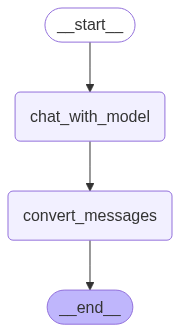

In [46]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [47]:
query="你好，请你介绍一下你自己"
input_message = {"messages": [{'role':'user', 'content':query}]}

result = graph.invoke(input_message)

print(result)

{'messages': [{'role': 'user', 'content': '你好，请你介绍一下你自己'}]}
-----------------
{'messages': [{'role': 'user', 'content': '你好，请你介绍一下你自己'}, {'role': 'assistant', 'content': '你好！我是通义千问，是阿里巴巴集团旗下的通义实验室自主研发的超大规模语言模型。我能够回答问题、创作文字、编程、逻辑推理等多种任务，旨在为用户提供全面、准确和有用的信息与帮助。\n\n我的训练数据来自大量的文本，包括书籍、文章、网页等，这让我能够理解和生成多种语言的内容。我可以帮助你学习知识、创作内容、解决技术问题，甚至进行简单的对话和娱乐互动。\n\n如果你有任何问题或需要帮助，随时告诉我，我会尽力为你提供支持！'}]}
-----------------
{'messages': [{'role': 'user', 'content': '你好，请你介绍一下你自己'}, {'role': 'assistant', 'content': '你好！我是通义千问，是阿里巴巴集团旗下的通义实验室自主研发的超大规模语言模型。我能够回答问题、创作文字、编程、逻辑推理等多种任务，旨在为用户提供全面、准确和有用的信息与帮助。\n\n我的训练数据来自大量的文本，包括书籍、文章、网页等，这让我能够理解和生成多种语言的内容。我可以帮助你学习知识、创作内容、解决技术问题，甚至进行简单的对话和娱乐互动。\n\n如果你有任何问题或需要帮助，随时告诉我，我会尽力为你提供支持！'}, {'role': 'assistant', 'content': '{\n  "key_data_points": {\n    "模型名称": "通义千问",\n    "所属机构": "阿里巴巴集团旗下的通义实验室",\n    "功能描述": [\n      "回答问题",\n      "创作文字",\n      "编程",\n      "逻辑推理"\n    ],\n    "训练数据来源": [\n      "书籍",\n      "文章",\n      "网页"\n    ],\n    "语言能力": "多种语言内容的理解与生成",\n    "应用场

In [49]:
print(result["messages"][-1]['content'])

{
  "key_data_points": {
    "模型名称": "通义千问",
    "所属机构": "阿里巴巴集团旗下的通义实验室",
    "功能描述": [
      "回答问题",
      "创作文字",
      "编程",
      "逻辑推理"
    ],
    "训练数据来源": [
      "书籍",
      "文章",
      "网页"
    ],
    "语言能力": "多种语言内容的理解与生成",
    "应用场景": [
      "学习知识",
      "创作内容",
      "解决技术问题",
      "简单的对话和娱乐互动"
    ],
    "目标": "为用户提供全面、准确和有用的信息与帮助"
  }
}


### 2.1.4 MessageGraph源码功能解析

更复杂一点的，如果我们还想手动更新图状态中的消息（例如人机交互），**使用`operator.add`能做到的功能极限是：发送到图的手动状态更新将被附加到现有的消息列表中，而不是更新现有的消息**。为了避免这种情况，我们则需要一个可以跟踪消息 ID 并覆盖现有消息（如果更新）的`Reducer`函数。为此，就引出了`LangGraph`预构建的`add_messages`函数，这个更高级的`Reducer`所实现的是：**对于全新的消息，它会附加到现有列表，但它也会正确处理现有消息的更新。如何理解这句话呢？我们接下来就从源码角度进行详细解析。**

`StateGraph`类，这个类允许我们创建图，其节点通过读取和写入共享状态进行通信。 `StateGraph` 类由开发者定义的 `State` 对象进行参数化，该对象表示图中的节点将通过其进行通信的共享数据结构。

`MessageGraph` 是 `StateGraph` 的一个子类，使用了 `Annotated[list[AnyMessage], add_messages]` 来初始化其基类 `StateGraph`。这里的 `list[AnyMessage]` 指明了 `MessageGraph` 的状态由消息列表组成，而这个列表类型是一个可以不断添加消息的结构（因为列表是可变的数据类型），`MessageGraph` 中的每个节点都将消息列表作为输入，并返回零个或多个消息作为输出。`add_messages`函数用于将每个节点的输出消息合并进图的状态中已存在的消息列表。其源码定义如下：

> MessageGraph 源码：https://github.com/langchain-ai/langgraph/blob/e3ef9adac7395e5c0943c22bbc8a4a856b103aa3/libs/langgraph/langgraph/graph/message.py#L150

```python
class MessageGraph(StateGraph):
    def __init__(self) -> None:
        super().__init__(Annotated[list[AnyMessage], add_messages]])
```

注意，当前版本MessageGraph已经移除了，使用StateGraph并传入`messages`

我们实际需要的是对消息的一种更新办法，当是旧消息时，进行更新，新消息进行追加。

In [52]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

msgs1 = [HumanMessage(content="你好。", id="1")]
msgs2 = [AIMessage(content="你好，很高兴认识你。", id="2")]

add_messages(msgs1, msgs2)

[HumanMessage(content='你好。', additional_kwargs={}, response_metadata={}, id='1'),
 AIMessage(content='你好，很高兴认识你。', additional_kwargs={}, response_metadata={}, id='2')]

In [53]:
msgs1 = [HumanMessage(content="你好。", id="1")]
msgs2 = [HumanMessage(content="你好呀。", id="1")]

add_messages(msgs1, msgs2)

[HumanMessage(content='你好呀。', additional_kwargs={}, response_metadata={}, id='1')]

In [64]:
msgs1 = [{"role": "assistant", "content": "Hello", 'id':"1"}]
msgs2 = [{"role": "user", "content": "Hi", 'id':"2"}]

from langgraph.graph.message import add_messages

merged = add_messages(msgs1, msgs2)
print(merged)

[AIMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='1'), HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='2')]


看起来，对于字典的消息也是可以用的，只不过涉及到结构的转化。因此我们还是基于State来构建历史消息。

In [65]:
def Msg2Dict(messages:list):
    dict_messages = []
    for msg in messages:
        if isinstance(msg, AIMessage):
            role = "assistant"
        elif isinstance(msg, HumanMessage):
            role = "user"
        else:
            role = "system"  # 如果还有 SystemMessage
        dict_messages.append({
            "role": role,
            "content": msg.content,
            "id": msg.id
        })
    return dict_messages

In [66]:
Msg2Dict(merged)

[{'role': 'assistant', 'content': 'Hello', 'id': '1'},
 {'role': 'user', 'content': 'Hi', 'id': '2'}]

In [54]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

`State`是一个带有单个键的`TypedDict` ： `messages` 。 `messages`键使用`add_messages`作为`Reducer`函数告诉 `LangGraph` 将新消息追加到现有列表中，而不是覆盖它。

这样我们就可以实现选中某个历史消息，修改内容重新传入的功能。

## 2.2 LangSmith

大模型具有不确定性，尤其是构建复杂`AI Agent`应用程序中，中间会涉及非常多的子步骤，如果想要了解每一步的运行状态和结果，一方面可以通过`Debug`来进行实时控制，而另一方面可以借助一些工具来观察和调试中间的交互流程。`Langsmith`就是这样一个工具平台， 由 `LangChain` 和 `LangGraph` 背后的团队创建，**主要作用是：为基于大语言模型构建的应用程序提供全面的监控、调试和可观察性。提供强大的跟踪、日志记录和实时分析功能。**

> LangSmith：https://smith.langchain.com/

通常，对于一个项目而言，可以是单个应用程序或服务。该项目将包含多个跟踪，每个跟踪都是运行的集合 - 一个运行代表应用程序中的一个基本操作，例如对 OpenAI 的 API 调用，或检索操作。如下图所示：

<div align=center><img src="https://muyu001.oss-cn-beijing.aliyuncs.com/img/image-20241022164041124.png" width=100%></div>

- **Project (项目)：**  
  蓝色方块代表整个项目，可能是一个独立的应用程序或服务。

- **Traces (轨迹)：**  
  绿色方块表示项目在不同条件或配置下的执行路径。每个轨迹可以是特定的用户会话、某个功能的执行，或应用在特定输入下的行为。

- **Runs (运行)：**  
  每个轨迹下的黄色方块表示该轨迹的单次执行。这些是执行实例，每个实例都是轨迹在特定条件下的实际运行。

- **Feedback, Tags, Metadata (反馈、标签、元数据)：**  
  显示系统如何利用用户或自动化工具生成的反馈、标签和元数据来增强轨迹的管理和筛选。反馈可以用于改进未来运行，标签和元数据可用于分类和筛选特定轨迹或运行，使其在 LangSmith 用户界面中更易管理和审查。


### 2.2.1 产品注册

要开始使用 `LangSmith`，我们需要创建一个帐户。可以在这里注册一个免费帐户进入`LangSmith`登录页面： https://smith.langchain.com/， 支持使用 Google、GitHub、Discord 和电子邮件登录。

在设置中导航至“API 密钥”部分，然后单击“创建 API 密钥” 。

### 2.2.2 运行一个简单示例

In [92]:
from dotenv import load_dotenv
import os

# 加载 .env 文件
load_dotenv('../config/.env')

# 获取模型 API 密钥
langsmith_api_key = os.getenv("LangSmith")

# 设置环境变量
import os

# 设置环境变量
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"] = "First Project"
os.environ["LANGSMITH_API_KEY"] = langsmith_api_key

# 验证环境变量是否设置成功
print(os.getenv("LANGSMITH_TRACING"))
print(os.getenv("LANGSMITH_API_KEY"))

true
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


In [93]:
from openai import OpenAI

# 获取模型 API 密钥
model_api_key = os.getenv("QWEN_API_KEY")

llm = OpenAI(
    api_key=model_api_key,
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"
)

In [90]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from openai import OpenAI


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

def chatbot(state: State):
    messages = state['messages']
    messages = Msg2Dict(messages)
    completion = llm.chat.completions.create(
        model="qwen-turbo-2025-04-28",
        messages=messages,
        extra_body={
            "enable_search": False,
            "enable_thinking": False
        }
    )
    response = completion.choices[0].message.content
    return {"messages": [{'role': "assistant", 'content': response}]}

graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

In [91]:
def stream_graph_updates(user_input: str):  
    for event in graph.stream({"messages": [{"role":"user", "content":user_input}]}):
        for value in event.values():
            print("模型回复:", value["messages"][-1]['content'])


while True:
    user_input = input("用户提问: ")
    if user_input.lower() in ["退出"]:
        print("下次再见！")
        break
    stream_graph_updates(user_input)

用户提问:  你好


模型回复: 你好！很高兴见到你。有什么我可以帮助你的吗？


用户提问:  我在测试langsmith


模型回复: 你好！很高兴你来测试 LangSmith。LangSmith 是一个用于构建、测试和调试语言模型应用的工具，它可以帮助你更好地理解和优化你的模型在实际应用中的表现。

如果你有任何问题或需要帮助的地方，请随时告诉我。比如：

- 如何设置 LangSmith？
- 如何使用 LangSmith 进行模型测试？
- 遇到了什么错误或问题？
- 想要了解 LangSmith 的某些功能？

我会尽力为你提供帮助！你目前在测试 LangSmith 时遇到了什么具体的问题吗？


用户提问:  你给我讲个短小的笑话


模型回复: 有一天，小明去理发店理发。理发师问他：“要剪什么发型？”  
小明说：“剪一个帅气的。”  
理发师点点头，开始剪。  
结果小明一照镜子，大喊：“这叫帅气？我像狗啃的！”  
理发师淡定地说：“不，这是‘汪星人’最新潮流。”


用户提问:  退出


下次再见！


In [97]:
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage

# 创建聊天模型对象
llm = ChatOpenAI(
    model_name="qwen-plus",   # 或者 qwen-7b, qwen-7b-chat 等
    temperature=0.7,
    max_tokens=512
)

# 调用模型
messages = [HumanMessage(content="请给我写一首关于秋天的诗。")]
response = llm(messages)

print(response.content)


AuthenticationError: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************yHoA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}